#**Paso 1: Leyendo los datos**

##**Importando los datos**

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('carros.csv')

In [3]:
df.head()

,Marca,Modelo,Año,Tipo_combustible,Potencia_motor,Cilindros_motor,Tipo_transmision,Ruedas_motrices,Numero_puertas,Tamaño,Estilo,Consumo_carretera_millas,Consumo_ciudad_millas,Valor($)
0,GMC,Envoy XL,2005,gasolina comun,275.0,6.0,automatico,tracción trasera,4.0,grande,SUV 4 puertas,18,13,29695
1,Volkswagen,Passat,2016,gasolina comun,170.0,4.0,automatico,tracción delantera,4.0,medio,sedán,38,25,30495
2,Honda,Odyssey,2016,gasolina comun,248.0,6.0,automatico,tracción delantera,4.0,grande,minivan de pasajeros,28,19,37650
3,Chevrolet,Cruze,2015,gasolina comun,138.0,4.0,manual,tracción delantera,4.0,medio,sedán,36,25,16170
4,Volvo,740,1991,gasolina comun,162.0,4.0,automatico,tracción trasera,4.0,medio,sedán,20,17,2000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10918 entries, 0 to 10917
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Marca                     10918 non-null  object 
 1   Modelo                    10918 non-null  object 
 2   Año                       10918 non-null  int64  
 3   Tipo_combustible          10918 non-null  object 
 4   Potencia_motor            10862 non-null  float64
 5   Cilindros_motor           10888 non-null  float64
 6   Tipo_transmision          10918 non-null  object 
 7   Ruedas_motrices           10918 non-null  object 
 8   Numero_puertas            10916 non-null  float64
 9   Tamaño                    10918 non-null  object 
 10  Estilo                    10918 non-null  object 
 11  Consumo_carretera_millas  10918 non-null  int64  
 12  Consumo_ciudad_millas     10918 non-null  int64  
 13  Valor($)                  10918 non-null  int64  
dtypes: flo

##**Procesando los datos**

In [5]:
df.duplicated().sum()

709

In [6]:
datos_limpios = df.drop_duplicates()
datos_limpios.reset_index(drop=True, inplace=True)

In [7]:
datos_limpios.shape

(10209, 14)

In [8]:
df_final = datos_limpios.copy()

object_columns = df_final.select_dtypes(include='object').columns
df_final[object_columns] = df_final[object_columns].astype('category')

In [9]:
df_final.dtypes

,0
Marca,category
Modelo,category
Año,int64
Tipo_combustible,category
Potencia_motor,float64
Cilindros_motor,float64
Tipo_transmision,category
Ruedas_motrices,category
Numero_puertas,float64
Tamaño,category


#**Paso 2: Entrenando un XGBoost**

##**Separando en bases de entrenamiento y prueba**

In [10]:
X = df_final.drop(['Valor($)'], axis=1)
y = df_final['Valor($)']

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)

##**Realizando predicciones con la API de Scikit-Learn**

In [14]:
import xgboost as xgb

In [15]:
model = xgb.XGBRegressor(objective='reg:squarederror', enable_categorical=True, n_estimators=100)

model.fit(X_train, y_train)
pred = model.predict(X_test)

##**Calculando métricas de desempeño**

In [16]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, pred)
print(f'MSE: {mse:.2f}')

MSE: 12158388.41


In [17]:
rmse = mean_squared_error(y_test, pred, squared=False)
print(f'RMSE: {rmse:.2f}')

RMSE: 3486.89


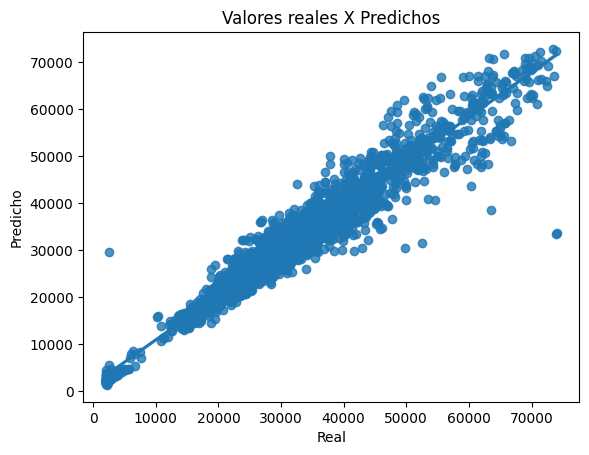

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.regplot(x=y_test, y=pred)
plt.xlabel('Real')
plt.ylabel('Predicho')
plt.title('Valores reales X Predichos')
plt.show()

##**Realizando predicciones con la API nativa de XGBoost**

In [19]:
dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [20]:
params = {'objective': 'reg:squarederror'}

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=100
)

pred = model.predict(dtest)

In [21]:
rmse = mean_squared_error(dtest.get_label(), pred, squared=False)
print(f'RMSE: {rmse:.2f}')

RMSE: 3486.89


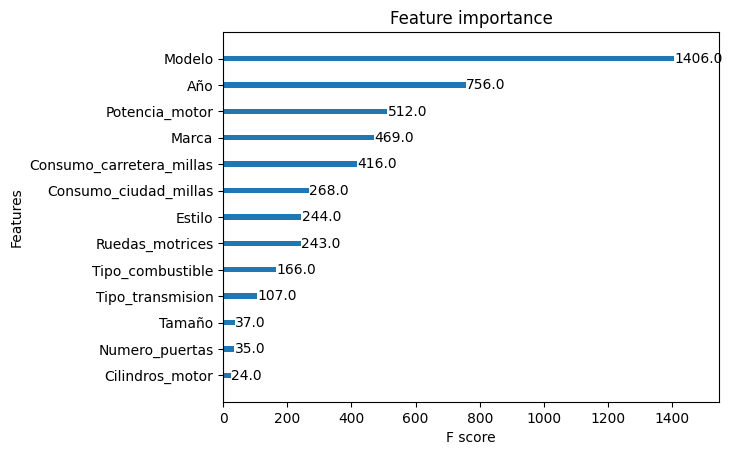

In [22]:
xgb.plot_importance(model)
plt.grid(False)
plt.show()

#**Paso 3: Realizando la validación del modelo**

##**Utilizando conjuntos de validación durante el entrenamiento**

In [23]:
params = {'objective': 'reg:squarederror'}
n = 100

evals = [(dtrain, 'entrenamiento'), (dtest, 'validacion')]

model = xgb.train(
    params=params,
    dtrain = dtrain,
    num_boost_round = n,
    evals=evals)

[0]	entrenamiento-rmse:11380.36384	validacion-rmse:11639.83920
[1]	entrenamiento-rmse:8422.49632	validacion-rmse:8774.90742
[2]	entrenamiento-rmse:6385.35172	validacion-rmse:6820.79437
[3]	entrenamiento-rmse:5004.51390	validacion-rmse:5539.23640
[4]	entrenamiento-rmse:4116.49989	validacion-rmse:4714.05366
[5]	entrenamiento-rmse:3557.64849	validacion-rmse:4230.74345
[6]	entrenamiento-rmse:3169.70808	validacion-rmse:3898.18586
[7]	entrenamiento-rmse:2942.87449	validacion-rmse:3714.56041
[8]	entrenamiento-rmse:2779.42694	validacion-rmse:3577.73709
[9]	entrenamiento-rmse:2645.93228	validacion-rmse:3478.51684
[10]	entrenamiento-rmse:2570.53658	validacion-rmse:3425.41482
[11]	entrenamiento-rmse:2502.54167	validacion-rmse:3398.66490
[12]	entrenamiento-rmse:2451.51619	validacion-rmse:3394.41733
[13]	entrenamiento-rmse:2417.72518	validacion-rmse:3381.70442
[14]	entrenamiento-rmse:2391.13916	validacion-rmse:3391.14533
[15]	entrenamiento-rmse:2372.92349	validacion-rmse:3382.22885
[16]	entrenamien

In [24]:
params = {'objective': 'reg:squarederror'}
n = 100

evals = [(dtrain, 'entrenamiento'), (dtest, 'validacion')]

model = xgb.train(
    params=params,
    dtrain = dtrain,
    num_boost_round = n,
    evals=evals,
    verbose_eval=10)

[0]	entrenamiento-rmse:11380.36384	validacion-rmse:11639.83920
[10]	entrenamiento-rmse:2570.53658	validacion-rmse:3425.41482
[20]	entrenamiento-rmse:2304.13215	validacion-rmse:3384.79407
[30]	entrenamiento-rmse:2225.73956	validacion-rmse:3387.64984
[40]	entrenamiento-rmse:2174.50946	validacion-rmse:3404.96409
[50]	entrenamiento-rmse:2147.83706	validacion-rmse:3425.13281
[60]	entrenamiento-rmse:2127.77469	validacion-rmse:3440.59820
[70]	entrenamiento-rmse:2109.79678	validacion-rmse:3456.96568
[80]	entrenamiento-rmse:2097.42314	validacion-rmse:3465.58038
[90]	entrenamiento-rmse:2084.29941	validacion-rmse:3475.60667
[99]	entrenamiento-rmse:2077.90690	validacion-rmse:3486.88806


In [25]:
params = {'objective': 'reg:squarederror'}
n = 1000

evals = [(dtrain, 'entrenamiento'), (dtest, 'validacion')]

model = xgb.train(
    params=params,
    dtrain = dtrain,
    num_boost_round = n,
    evals=evals,
    early_stopping_rounds=10)

[0]	entrenamiento-rmse:11380.36384	validacion-rmse:11639.83920
[1]	entrenamiento-rmse:8422.49632	validacion-rmse:8774.90742
[2]	entrenamiento-rmse:6385.35172	validacion-rmse:6820.79437
[3]	entrenamiento-rmse:5004.51390	validacion-rmse:5539.23640
[4]	entrenamiento-rmse:4116.49989	validacion-rmse:4714.05366
[5]	entrenamiento-rmse:3557.64849	validacion-rmse:4230.74345
[6]	entrenamiento-rmse:3169.70808	validacion-rmse:3898.18586
[7]	entrenamiento-rmse:2942.87449	validacion-rmse:3714.56041
[8]	entrenamiento-rmse:2779.42694	validacion-rmse:3577.73709
[9]	entrenamiento-rmse:2645.93228	validacion-rmse:3478.51684
[10]	entrenamiento-rmse:2570.53658	validacion-rmse:3425.41482
[11]	entrenamiento-rmse:2502.54167	validacion-rmse:3398.66490
[12]	entrenamiento-rmse:2451.51619	validacion-rmse:3394.41733
[13]	entrenamiento-rmse:2417.72518	validacion-rmse:3381.70442
[14]	entrenamiento-rmse:2391.13916	validacion-rmse:3391.14533
[15]	entrenamiento-rmse:2372.92349	validacion-rmse:3382.22885
[16]	entrenamien

##**Ejecutando una validacion cruzada**

In [26]:
params = {'objective': 'reg:squarederror'}

cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=5, num_boost_round=1000,
                       early_stopping_rounds=10, metrics='rmse', as_pandas=True, seed=1234)

cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,11367.912612,51.166960,11545.178087,192.137411
1,8401.350154,38.794201,8731.068390,133.335785
2,6394.472627,42.503636,6855.005644,81.846116
3,5056.825254,72.978047,5638.120670,67.807789
4,4157.352656,60.948151,4877.524607,71.991048
5,3567.959639,51.169771,4400.278650,86.271522
6,3174.048239,46.006399,4104.229275,106.529292
7,2915.201877,46.283929,3911.727484,120.997544
8,2737.201093,30.783655,3788.284683,135.631678
9,2609.745101,30.999799,3700.243329,134.290313


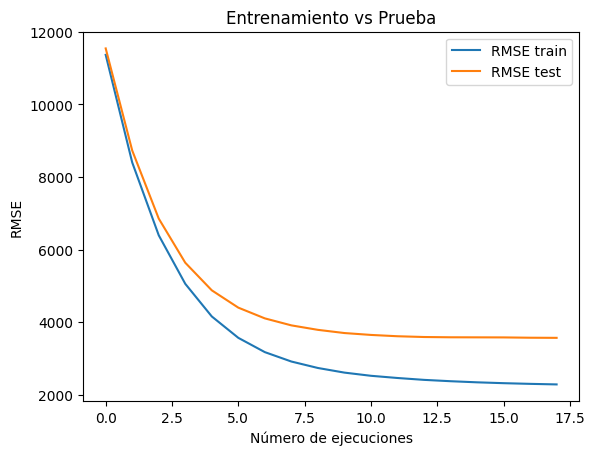

In [27]:
iteraciones = range(len(cv_results))

plt.plot(iteraciones, cv_results['train-rmse-mean'], label='RMSE train')
plt.plot(iteraciones, cv_results['test-rmse-mean'], label='RMSE test')
plt.title('Entrenamiento vs Prueba')
plt.xlabel('Número de ejecuciones')
plt.ylabel('RMSE')
plt.legend()
plt.show()

#**Paso 4: Ajustando hiperparametros de XGBoost**

##**Buscando mejores hiperparametros con GridSearchCV**

In [28]:
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {
    'colsample_bytree': [0.6, 1],
    'subsample': [0.5, 0.8, 1],
    'max_depth': [3, 5, 10]
}

gbm = xgb.XGBRegressor(enable_categorical=True)

grid = GridSearchCV(
    estimator = gbm,
    param_grid = param_grid,
    scoring = 'neg_mean_squared_error',
    cv = 5,
    verbose = 1
)

grid.fit(X, y)

print('Mejores hiperparametros encontrados: ', grid.best_params_)
print('Menor RMSE encontrado: ', np.sqrt(np.abs(grid.best_score_)))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Mejores hiperparametros encontrados:  {'colsample_bytree': 0.6, 'max_depth': 3, 'subsample': 1}
Menor RMSE encontrado:  2997.427005054711


##**Impacto de la taza de aprendizaje**

[0]	entrenamiento-rmse:15601.96070	validacion-rmse:15739.20372
[100]	entrenamiento-rmse:8145.18065	validacion-rmse:8455.54342
[200]	entrenamiento-rmse:5033.33542	validacion-rmse:5427.22607
[300]	entrenamiento-rmse:3799.39656	validacion-rmse:4223.55048
[400]	entrenamiento-rmse:3276.57739	validacion-rmse:3713.71073
[500]	entrenamiento-rmse:3027.18320	validacion-rmse:3474.24893
[600]	entrenamiento-rmse:2885.08679	validacion-rmse:3348.62209
[700]	entrenamiento-rmse:2795.42084	validacion-rmse:3265.06057
[800]	entrenamiento-rmse:2734.82812	validacion-rmse:3214.44731
[900]	entrenamiento-rmse:2688.42985	validacion-rmse:3182.10794
[999]	entrenamiento-rmse:2652.59663	validacion-rmse:3161.76872


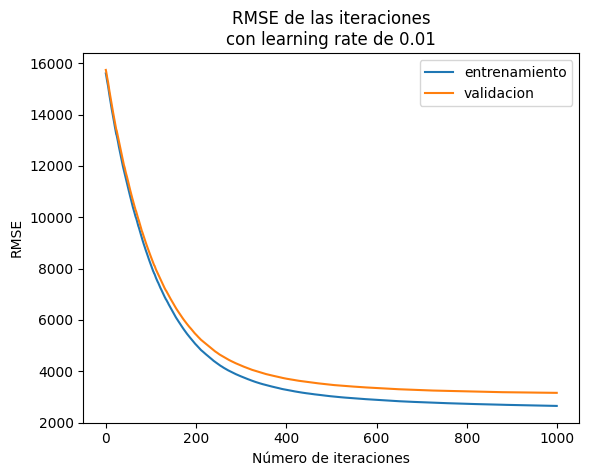

In [29]:
params = {'objective': 'reg:squarederror', 'colsample_bytree': 0.6, 'max_depth': 3, 'subsample': 1,
          'learning_rate': 0.01}

evals_result = {}

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=10,
    verbose_eval=100,
    evals=[(dtrain, 'entrenamiento'), (dtest, 'validacion')],
    evals_result=evals_result
)

train_rmse = evals_result['entrenamiento']['rmse']
validation_rmse = evals_result['validacion']['rmse']

plt.plot(train_rmse, label='entrenamiento')
plt.plot(validation_rmse, label='validacion')
plt.xlabel('Número de iteraciones')
plt.ylabel('RMSE')
plt.title('RMSE de las iteraciones\ncon learning rate de 0.01')
plt.legend()
plt.show()

##**Explorando diferentes tazas de aprendizaje**

[0]	entrenamiento-rmse:14506.90572	validacion-rmse:14674.56126
[100]	entrenamiento-rmse:2727.05304	validacion-rmse:3227.60885
[200]	entrenamiento-rmse:2510.51461	validacion-rmse:3094.07453
[300]	entrenamiento-rmse:2412.87711	validacion-rmse:3037.82616
[333]	entrenamiento-rmse:2397.61738	validacion-rmse:3031.52960


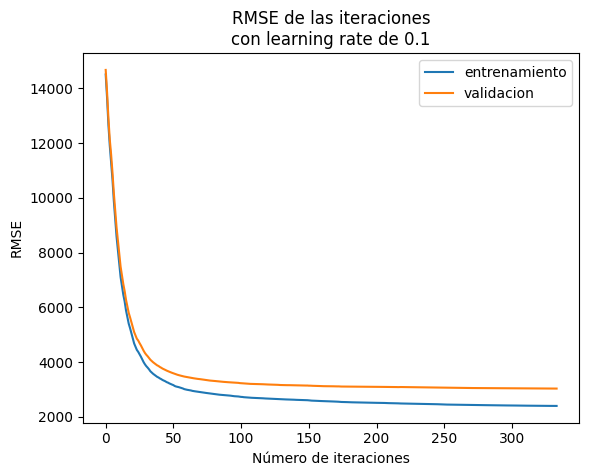

In [30]:
params = {'objective': 'reg:squarederror', 'colsample_bytree': 0.6, 'max_depth': 3, 'subsample': 1,
          'learning_rate': 0.1}

evals_result = {}

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=10,
    verbose_eval=100,
    evals=[(dtrain, 'entrenamiento'), (dtest, 'validacion')],
    evals_result=evals_result
)

train_rmse = evals_result['entrenamiento']['rmse']
validation_rmse = evals_result['validacion']['rmse']

plt.plot(train_rmse, label='entrenamiento')
plt.plot(validation_rmse, label='validacion')
plt.xlabel('Número de iteraciones')
plt.ylabel('RMSE')
plt.title('RMSE de las iteraciones\ncon learning rate de 0.1')
plt.legend()
plt.show()

[0]	entrenamiento-rmse:7300.09065	validacion-rmse:7671.62080
[100]	entrenamiento-rmse:2349.71324	validacion-rmse:3158.47933
[113]	entrenamiento-rmse:2328.53509	validacion-rmse:3158.79220


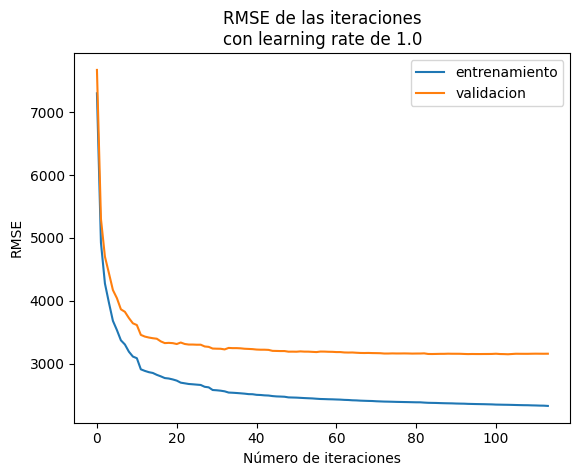

In [31]:
params = {'objective': 'reg:squarederror', 'colsample_bytree': 0.6, 'max_depth': 3, 'subsample': 1,
          'learning_rate': 1.0}

evals_result = {}

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=10,
    verbose_eval=100,
    evals=[(dtrain, 'entrenamiento'), (dtest, 'validacion')],
    evals_result=evals_result
)

train_rmse = evals_result['entrenamiento']['rmse']
validation_rmse = evals_result['validacion']['rmse']

plt.plot(train_rmse, label='entrenamiento')
plt.plot(validation_rmse, label='validacion')
plt.xlabel('Número de iteraciones')
plt.ylabel('RMSE')
plt.title('RMSE de las iteraciones\ncon learning rate de 1.0')
plt.legend()
plt.show()

[0]	entrenamiento-rmse:12182.52354	validacion-rmse:12420.89673
[100]	entrenamiento-rmse:2431.62268	validacion-rmse:3109.26152
[134]	entrenamiento-rmse:2384.11710	validacion-rmse:3089.56413


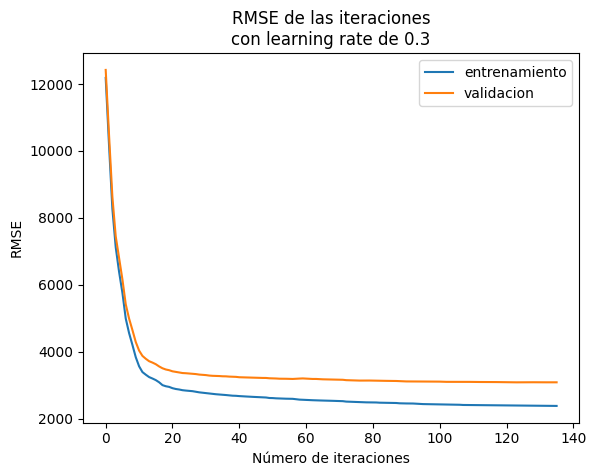

In [32]:
params = {'objective': 'reg:squarederror', 'colsample_bytree': 0.6, 'max_depth': 3, 'subsample': 1,
          'learning_rate': 0.3}

evals_result = {}

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=10,
    verbose_eval=100,
    evals=[(dtrain, 'entrenamiento'), (dtest, 'validacion')],
    evals_result=evals_result
)

train_rmse = evals_result['entrenamiento']['rmse']
validation_rmse = evals_result['validacion']['rmse']

plt.plot(train_rmse, label='entrenamiento')
plt.plot(validation_rmse, label='validacion')
plt.xlabel('Número de iteraciones')
plt.ylabel('RMSE')
plt.title('RMSE de las iteraciones\ncon learning rate de 0.3')
plt.legend()
plt.show()

#**Paso 5: Ejecutando el modelo**

##**Evaluando el desempeño del modelo final**

In [33]:
params = {'objective': 'reg:squarederror', 'colsample_bytree': 0.6, 'max_depth': 3, 'subsample': 1,
          'learning_rate': 0.3}

modelo_final = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=170
)

preds = modelo_final.predict(dtest)
rmse = mean_squared_error(dtest.get_label(), preds, squared=False)
print(f'RMSE: {rmse:.2f}')

RMSE: 3073.87


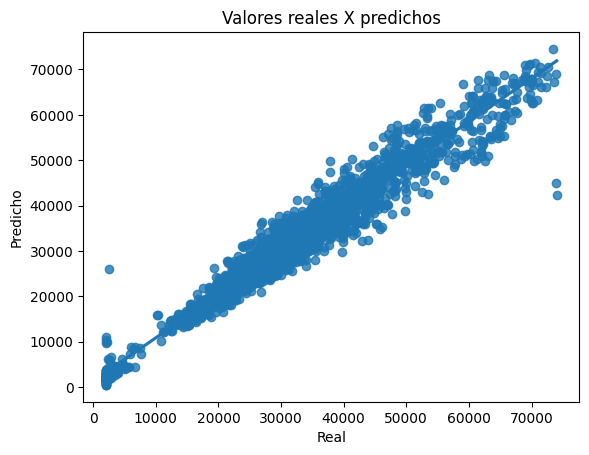

In [34]:
sns.regplot(x=dtest.get_label(), y=preds)
plt.xlabel('Real')
plt.ylabel('Predicho')
plt.title('Valores reales X predichos')
plt.show()

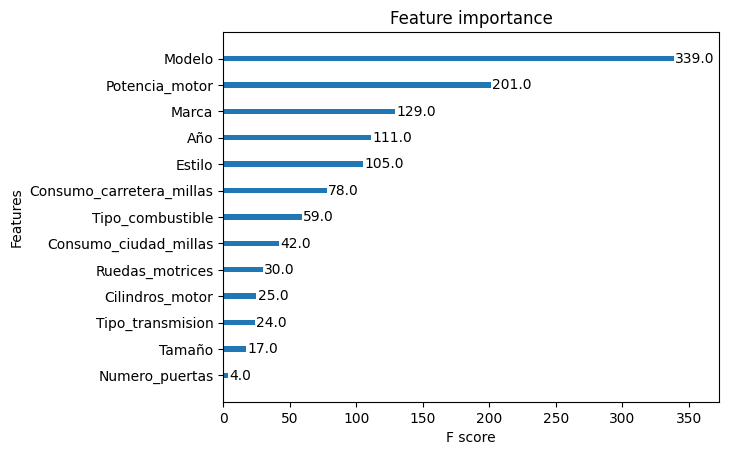

In [35]:
xgb.plot_importance(modelo_final)
plt.grid(False)
plt.show()

##**Evaluando el desempeño del modelo con Cross Validation**

In [36]:
params = {'objective': 'reg:squarederror', 'colsample_bytree': 0.6, 'max_depth': 3, 'subsample': 1,
          'learning_rate': 0.3}

cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=5, num_boost_round=1000,
                       early_stopping_rounds=10, metrics='rmse', as_pandas=True, seed=1234)

cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,12183.019767,49.070877,12192.624527,213.941693
1,10127.154061,30.552486,10365.520548,152.444510
2,8214.544070,22.677393,8578.727968,99.008518
3,7081.579521,22.372685,7473.158386,65.357521
4,6327.276936,33.522989,6815.772116,60.519000
...,...,...,...,...
177,2287.453309,14.723481,3214.953638,79.834061
178,2286.907678,14.697906,3214.886232,79.735197
179,2285.832312,14.743618,3214.676034,79.051351
180,2284.866225,14.519517,3214.196591,78.797528


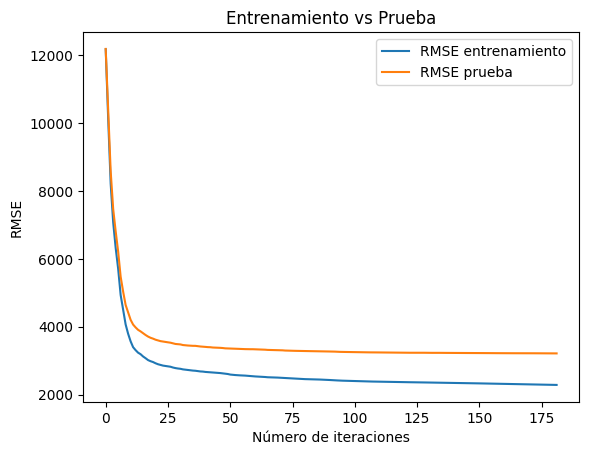

In [37]:
iteraciones = range(len(cv_results))

plt.plot(iteraciones, cv_results['train-rmse-mean'], label='RMSE entrenamiento')
plt.plot(iteraciones, cv_results['test-rmse-mean'], label='RMSE prueba')
plt.title('Entrenamiento vs Prueba')
plt.xlabel('Número de iteraciones')
plt.ylabel('RMSE')
plt.legend()
plt.show()

##**Utilizando el modelo con nuevos datos**

In [38]:
import joblib

joblib.dump(modelo_final, 'modelo_xgb.pkl')

['modelo_xgb.pkl']

In [39]:
modelo = joblib.load('modelo_xgb.pkl')

In [40]:
nuevos_carros = pd.read_csv('nuevos_carros.csv')

In [41]:
nuevos_carros

,Marca,Modelo,Año,Tipo_combustible,Potencia_motor,Cilindros_motor,Tipo_transmision,Ruedas_motrices,Numero_puertas,Tamaño,Estilo,Consumo_carretera_millas,Consumo_ciudad_millas
0,Subaru,Impreza WRX,2013,gasolina premium (obligatoria),305.0,4.0,manual,tracción integral,4.0,compacto,sedán,22,15
1,Honda,Insight,2012,gasolina comun,98.0,4.0,automatico,tracción delantera,4.0,compacto,hatchback 4 puertas,49,38
2,Volvo,XC90,2015,gasolina premium (recomendada),250.0,4.0,automatico,tracción delantera,4.0,grande,SUV 4 puertas,25,20
3,Honda,HR-V,2016,gasolina comun,141.0,4.0,automatico,tracción integral,4.0,compacto,SUV 4 puertas,32,28


In [42]:
object_columns = nuevos_carros.select_dtypes(include='object').columns
nuevos_carros[object_columns] = nuevos_carros[object_columns].astype('category')

In [43]:
datos_nuevos = xgb.DMatrix(nuevos_carros, enable_categorical=True)

In [44]:
predicciones = modelo.predict(datos_nuevos)

In [45]:
df_nuevos_carros = pd.DataFrame(nuevos_carros)
df_nuevos_carros['Predicciones'] = predicciones

In [46]:
df_nuevos_carros

,Marca,Modelo,Año,Tipo_combustible,Potencia_motor,Cilindros_motor,Tipo_transmision,Ruedas_motrices,Numero_puertas,Tamaño,Estilo,Consumo_carretera_millas,Consumo_ciudad_millas,Predicciones
0,Subaru,Impreza WRX,2013,gasolina premium (obligatoria),305.0,4.0,manual,tracción integral,4.0,compacto,sedán,22,15,46301.191406
1,Honda,Insight,2012,gasolina comun,98.0,4.0,automatico,tracción delantera,4.0,compacto,hatchback 4 puertas,49,38,18742.060547
2,Volvo,XC90,2015,gasolina premium (recomendada),250.0,4.0,automatico,tracción delantera,4.0,grande,SUV 4 puertas,25,20,43048.570312
3,Honda,HR-V,2016,gasolina comun,141.0,4.0,automatico,tracción integral,4.0,compacto,SUV 4 puertas,32,28,27432.181641
